- Using frozen SimCLR as backbone, then bottleneck layer (maybe linear) trained on SimCLR features with MaxEnt loss
- Test SimCLR features here for few shot segmentation vs. e.g. linear layer classification

# Init

In [1]:
import numpy as np
import sys
import os
import torch
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F

import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

dframe = pd.DataFrame

#%matplotlib notebook
#%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/heka/code/retrieval_app


# SimCLR

In [2]:
from core.resnet_wider import resnet50x4

with torch.no_grad():
    repnet = resnet50x4().cuda()
repnet.eval()
print()

repnet_pth = '/home/heka/model_data/resnet50-4x.pth'
state_dict = torch.load(repnet_pth)['state_dict']
repnet.load_state_dict(state_dict)

<All keys matched successfully>

## Test with OpenImages:

In [50]:
if 1:  # validation set
    class_names_bbox = pd.read_csv('https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv',header=None).to_dict()
    class_names_seg = pd.read_csv('https://storage.googleapis.com/openimages/v5/classes-segmentation.txt', header=None).to_dict()
    df_masks = pd.read_csv('https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv')
    image_meta = pd.read_csv('https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv')

    mask_root = '/media/heka/TERA/Data/openimages_val_masks'

idx2name_bbox = class_names_bbox[0]
name2idx_bbox = {val: key for key, val in idx2name_bbox.items()}
idx2description_bbox = class_names_bbox[1]
description2idx_bbox = {val: key for key, val in idx2description_bbox.items()}
idx2name_seg = class_names_seg[0]
name2idx_seg = {val: key for key, val in idx2name_seg.items()}
num_classes_seg = len(class_names_seg[0])

In [49]:
image_meta.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,fe600639ac5f36c1,validation,https://farm2.staticflickr.com/5612/1534025949...,https://www.flickr.com/photos/118815643@N04/15...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/118815643@N04/,LabHacker CD,_GUT6674,242145,0jBpbNION09+r02xkTIBcA==,https://c8.staticflickr.com/6/5612/15340259497...,NaN
1,ba82c70cc6cdf449,validation,https://farm4.staticflickr.com/3859/1527670200...,https://www.flickr.com/photos/125612851@N04/15...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/125612851@N04/,Stockholms stadsarkiv,SE_SSA_0870_Ofört_029,1658910,qMzF2UrrpPdjO+Nhhl6pvQ==,https://c7.staticflickr.com/4/3859/15276702002...,0.0
2,e3ffa4c868b11b15,validation,https://farm6.staticflickr.com/5336/1717037798...,https://www.flickr.com/photos/101125222@N02/17...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/101125222@N02/,Ismaïl Taha,ct26,1085575,MXOLnofbdq410OH34woSeg==,https://c3.staticflickr.com/6/5336/17170377986...,0.0
3,7d00af2927a57eeb,validation,https://c4.staticflickr.com/7/6181/6085189538_...,https://www.flickr.com/photos/66833578@N02/608...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/66833578@N02/,Crycks,Hummingbird,126933,m0dy5a3Pjhbzx15MbScpxg==,https://c5.staticflickr.com/7/6181/6085189538_...,0.0
4,914dd6fb5eb17e85,validation,https://farm6.staticflickr.com/3324/4621899397...,https://www.flickr.com/photos/damo1977/4621899397,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/damo1977/,damo1977,"Christmas 1994 Hoticulture, Nuts & Dried Fruit...",855508,xeHPBJGWTrDVbOufALMFGw==,https://c6.staticflickr.com/4/3324/4621899397_...,NaN


In [112]:
# interesting fashion/prod search segmentation classes:
seg_interesting_classes = ['Clothing', 'Dress', 'Lipstick', 'Luggage and bags', 'Belt', 'Pen', 'Couch', 'Oven', 'High heels', 
                           'Suit', 'Backpack', 'Suitcase', 'Clock', 'Scarf', 'Camera', 'Handbag', 'Swim cap', 'Jeans', 'Plastic bag', 
                          'Hat', 'Baseball glove', 'Sun hat', 'Briefcase', 'Sock', 'Shirt', 'Glove', 'Towel', 'Fedora', 'Sombrero',
                          'Cowboy hat', 'Watch', 'Shorts', 'Skirt', 'Miniskirt']

Number of masks with class "Dress" = 278
https://c5.staticflickr.com/3/2949/15269001397_e375f5284e_z.jpg


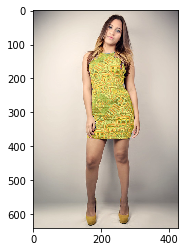

In [111]:
import os
from PIL import Image

from core.dataio import image_from_url

cls_this = 'Dress'
id_item = 4


idx = description2idx_bbox[cls_this]
name = idx2name_bbox[idx]

df_masks_name = df_masks[df_masks.LabelName == name]
print(f'Number of masks with class "{cls_this}" = {len(df_masks_name)}')

mask_path = df_masks_name.MaskPath.values[id_item]
image_id = df_masks_name.ImageID.values[id_item]
mask_path = os.path.join(mask_root, mask_path)
image_url = image_meta[image_meta.ImageID == image_id].OriginalURL.values[0]
image_url = image_url.replace('_o.jpg', '_z.jpg')  # lower res
print(image_url)

mask = Image.open(mask_path)
img = image_from_url(image_url)

# resize mask to img shape:
h = img.height
w = img.width
mask = np.array(mask.resize(img.size))
mask_plt = mask.copy().astype(np.float32)
mask_plt[mask_plt == False] = np.nan
img = np.array(img)

assert img.shape[:-1] == mask.shape

plt.imshow(img)
plt.imshow(mask_plt, vmin=0.5, alpha=0.5)
plt.show()

### Number of interesting class examples:

In [119]:
if 1:  # training set
    df_masks = pd.read_csv('https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv')  # takes a while to load...

numbers = list()
for i, seg_cls in enumerate(seg_interesting_classes):
    #print(f'\r{i}', end='')
    idx = description2idx_bbox[seg_cls]
    name = idx2name_bbox[idx]
    df_masks_name = df_masks[df_masks.LabelName == name]
    num = len(df_masks_name)
    numbers.append(num)
    print(f'{seg_cls} : {num}')


Clothing : 414489
Dress : 47605
Lipstick : 821
Luggage and bags : 1910
Belt : 386
Pen : 1443
Couch : 4072
Oven : 609
High heels : 2522
Suit : 100410
Backpack : 1082
Suitcase : 586
Clock : 977
Scarf : 2155
Camera : 5094
Handbag : 2294
Swim cap : 482
Jeans : 61076
Plastic bag : 839
Hat : 10715
Baseball glove : 1461
Sun hat : 5742
Briefcase : 147
Sock : 1222
Shirt : 7168
Glove : 1022
Towel : 260
Fedora : 3178
Sombrero : 600
Cowboy hat : 2556
Watch : 1724
Shorts : 12613
Skirt : 1055
Miniskirt : 857


## Database:

In [5]:
from core.dataio import Database
from core.dataio import image_from_url
from core.augs import load_augs
from pprint import pprint
from detectron2.data import MetadataCatalog, DatasetCatalog

catalog = MetadataCatalog.get('coco_2017_train_panoptic_separated')
thing_classes = catalog.thing_classes
stuff_classes = catalog.stuff_classes
imagenet_classes = pd.read_csv('/home/heka/code/simclr-converter/metadata/imagenet_classes.txt', header=None, index_col=[0])

db_path = 'open-images-dataset-train0_0_475000.h5'
database = Database(db_path, mode='r', title=None)

augs = load_augs(resize_to=256)

Trying to load database from /home/heka/model_data/open-images-dataset-train0_0_475000.h5


index=341096
{'h': 0.1282,
 'is_thing': True,
 'pred': b'person',
 'url': b'https://c6.staticflickr.com/9/8264/8661741318_8d8ed2e82d_z.jpg',
 'w': 0.6206}


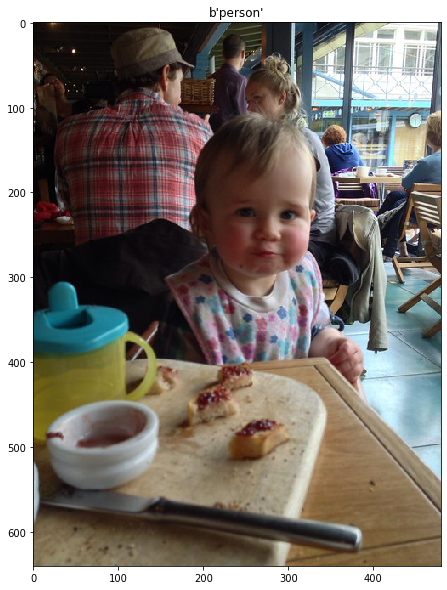

In [11]:
i = np.random.randint(400000)
#i = 60449
print(f'index={i}')

code, entity = database[i]
pprint(entity)

pred = entity['pred']
pred_h = entity['h']
pred_w = entity['w']
is_thing = entity['is_thing']

img = image_from_url(entity['url'])
#img = augs['augs_base'](img)
img_np = np.array(img)
h, w = img_np.shape[:-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title(pred)
ax.imshow(img_np)
plt.show()

In [7]:
entity

{'h': 0.6562,
 'is_thing': True,
 'pred': b'person',
 'url': b'https://c4.staticflickr.com/4/3184/2841807128_f00fd1ef8a_z.jpg',
 'w': 0.533}

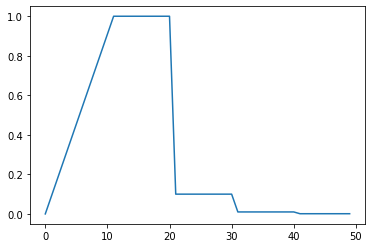

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from munch import Munch

args = Munch(warmup_peak=10,
            decay_at_epochs=[20, 30, 40],
            lr_decay_gamma=0.1)

def lr_lambda(step):
    warmup_peak = args.warmup_peak
    decay_at_epochs = np.array(args.decay_at_epochs)
    gamma = args.lr_decay_gamma
    assert warmup_peak < np.min(decay_at_epochs)
    if step <= warmup_peak:
        return step / (warmup_peak + 1)
    else:
        stage = np.sum(step > decay_at_epochs)
        return gamma ** stage
    
vals = list()
for step in np.arange(50):
    vals.append(lr_lambda(step))
    
plt.plot(vals)

In [45]:
decay_at_epochs = np.array([20, 30, 40])
gamma = 25

stage = np.sum(gamma > decay_at_epochs)
print(stage)



1


In [50]:
np.sqrt(80) * 0.001

0.00894427190999916

In [55]:
import torch

torch.randn(1, 3)

tensor([[-0.3485,  1.1384,  0.1093]])

In [90]:
import torch
import torch.nn.functional as F


B = 2
C = 3

target = torch.randint(0, 2, [B, C]).float()
print(target)
logit = torch.randn([B, C])
print(logit)
#weight = torch.ones([B, C])
weight = torch.tensor([[1, 1, .01], 
                       [0., 0, 1.]])

xent = F.binary_cross_entropy_with_logits(logit, target, weight=weight, size_average=None,
                                   reduction='none', pos_weight=torch.tensor(100))
print(xent)

tensor([[1., 1., 1.],
        [0., 1., 1.]])
tensor([[ 2.6117, -0.3658, -0.6672],
        [-0.2883,  1.0922, -1.2040]])
tensor([[  7.0843,  89.2661,   1.0814],
        [  0.0000,   0.0000, 146.6362]])


In [68]:
target

tensor([[1, 1, 0],
        [1, 1, 1]], dtype=torch.int32)

In [110]:
from sklearn.metrics import average_precision_score

B = 2
C = 3
target = np.random.randint(0, 2, [B, C]).astype(np.float)
print(target)

if 0:  # just random
    logit = np.random.randn(B, C)
if 1:  # perfect
    logit = (target - 0.5) * np.random.rand(B, C) * 10
print(logit)

target = target.flatten()  # [B * C, ]; AP for each binary classification
logit = logit.flatten()  # [B * C, ]

ap = average_precision_score(target, logit)
print(ap)

[[0. 0. 1.]
 [1. 1. 0.]]
[[-1.06324106 -1.13614746  0.63447941]
 [ 2.25725585  2.69850938 -4.53865635]]
1.0


In [124]:
B = 4
C = 3
target = np.random.randint(-1, 2, [B, C])
print(target)

if 0:  # just random
    logit = np.random.randn(B, C)
if 1:  # perfect
    logit = (target - 0.5) * np.random.rand(B, C) * 10
print(logit)



[[-1 -1  1]
 [ 1 -1  1]
 [ 0  0  0]
 [ 1 -1  1]]
[[-4.48386177 -9.97254959  4.67880824]
 [ 4.50116278 -9.4056946   4.78324506]
 [-4.60944905 -3.51038824 -3.13078746]
 [ 3.51581805 -1.86987913  3.60368504]]


In [6]:
np.random.seed(1)
np.random.randn(1)

array([1.62434536])

In [125]:
1e-3 * np.sqrt(40 * 8)

0.01788854381999832

# Index

## Simple tests:

In [24]:
H = 16
C = 2048

x = np.random.randn(H, H, C).astype(np.float32)
x.nbytes / 1000000

2.097152

In [18]:
H = 16
C = 2048

x = np.random.randn(H, H, C).astype(np.uint8)
x.nbytes / 1000000

0.524288

In [21]:
H = 16
C = 2048

x = np.random.randn(H, H, C).astype(np.float16)
x.nbytes / 1000000

1.048576

In [30]:
C = 128
x = np.random.randn(C).astype(np.float16)
print((x.nbytes / 1000000000) * 25000000)
x = np.random.randn(C).astype(np.uint8)
print((x.nbytes / 1000000000) * 25000000)


6.4
3.2


# Unsupervised segmentation

**PLAN**

- Something like Shi et al, "Normalized Cuts and Image Segmentation" (paperpile)
- First project from 2048 to 128 by uniform KL target using FC features
- Maybe store all features somewhere (feature store)
- Compare raw 2048 rep vs 128 dim (raw will probably have some regional dependencies)
- Test patch-wise inference

**NOTES**
- OK so unsup segmentation from fully convolutional feature pixels doesn't seem like a great idea...


## Models:

### SimCLR:

In [2]:
%cd /home/heka/code/retrieval_app

from core.resnet_wider import resnet50x4

with torch.no_grad():
    model = resnet50x4().cuda()
model.eval()
print()

repnet_pth = '/home/heka/model_data/resnet50-4x.pth'
state_dict = torch.load(repnet_pth)['state_dict']
model.load_state_dict(state_dict)

/home/heka/code/retrieval_app



<All keys matched successfully>

### SwAV:

In [79]:
import torch
import os
from core.swav import resnet50
#model = torch.hub.load('facebookresearch/swav', 'resnet50')
#model.eval_mode = True  # returns features in eval mode!

model_url = 'https://dl.fbaipublicfiles.com/vissl/model_zoo/swav_in1k_rn50_800ep_swav_8node_resnet_27_07_20.a0a6b676/model_final_checkpoint_phase799.torch'

model = resnet50(eval_mode=True)

In [94]:
state_dict = torch.load('resnet_swav.torch')['classy_state_dict']['base_model']['model']['trunk']

In [92]:
state_dict['model'].keys()

dict_keys(['trunk', 'heads'])

In [102]:
import torch
import os

!mkdir -p configs/config/swav
!mkdir -p vissl/config
!wget -q -O configs/config/swav/swav_8node_resnet.yaml https://raw.githubusercontent.com/facebookresearch/vissl/master/configs/config/pretrain/swav/swav_8node_resnet.yaml
!wget -q -O vissl/config/defaults.yaml https://raw.githubusercontent.com/facebookresearch/vissl/master/vissl/config/defaults.yaml

In [ ]:
# download model:
!wget -q -O resnet_swav.torch https://dl.fbaipublicfiles.com/vissl/model_zoo/swav_in1k_rn50_800ep_swav_8node_resnet_27_07_20.a0a6b676/model_final_checkpoint_phase799.torch

In [106]:
from omegaconf import OmegaConf
from vissl.utils.hydra_config import AttrDict

config = OmegaConf.load("configs/config/swav/swav_8node_resnet.yaml")
default_config = OmegaConf.load("vissl/config/defaults.yaml")
cfg = OmegaConf.merge(default_config, config)

In [151]:
# Edit the configuration to freeze the trunk (inference mode) and ask for the extraction of the last layer feature.
cfg = AttrDict(cfg)
cfg.config.MODEL.WEIGHTS_INIT.PARAMS_FILE = "resnet_swav.torch"
cfg.config.MODEL.FEATURE_EVAL_SETTINGS.EVAL_MODE_ON = True
cfg.config.MODEL.FEATURE_EVAL_SETTINGS.FREEZE_TRUNK_ONLY = True
cfg.config.MODEL.FEATURE_EVAL_SETTINGS.EXTRACT_TRUNK_FEATURES_ONLY = True
cfg.config.MODEL.FEATURE_EVAL_SETTINGS.SHOULD_FLATTEN_FEATS = False
#cfg.config.MODEL.FEATURE_EVAL_SETTINGS.LINEAR_EVAL_FEAT_POOL_OPS_MAP = [["res5avg", ["Identity", []]]]
cfg.config.MODEL.FEATURE_EVAL_SETTINGS.LINEAR_EVAL_FEAT_POOL_OPS_MAP = []

In [152]:
from vissl.models import build_model

model = build_model(cfg.config.MODEL, cfg.config.OPTIMIZER).cuda()

In [159]:
from classy_vision.generic.util import load_checkpoint
from vissl.utils.checkpoint import init_model_from_weights

weights = load_checkpoint(checkpoint_path=cfg.config.MODEL.WEIGHTS_INIT.PARAMS_FILE)

init_model_from_weights(
    config=cfg.config,
    model=model,
    state_dict=weights,
    state_dict_key_name="classy_state_dict",
    skip_layers=[-1],  # Use this if you do not want to load all layers
)

print("Loaded...")

TypeError: 'in <string>' requires string as left operand, not int

### PixPro:

In [18]:
%cd /home/heka/code/PixPro/

from contrast.resnet import resnet50

model = resnet50(head_type='early_return')

# load model params:
pretrained_model = 'pixpro_base_r50_400ep_md5_919c6612.pth'
config_url = 'https://github.com/zdaxie/PixPro/blob/main/transfer/detection/configs/COCO_R_50_C4_1x.yaml'

ckpt = torch.load(pretrained_model, map_location='cpu')
state_dict = ckpt['model']

# pick only encoder params:
state_dict_encoder = dict()
for key, val in state_dict.items():
    if 'encoder' in key:
        key_new = '.'.join(key.split('.')[2:])
        state_dict_encoder[key_new] = val

model.load_state_dict(state_dict_encoder, strict=True)
model = model.cuda()
model.eval()
print()

/home/heka/code/PixPro



## Fully conv unsupervised segmentation:

In [5]:
import torchvision.transforms as transforms
from core.augs import CropToMultiple
from core.utils import image_from_url

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
crop_size = 256

# transforms from SwAV repo: https://github.com/facebookresearch/swav/blob/master/src/multicropdataset.py
augs = transforms.Compose([
        transforms.Resize(crop_size),  # smaller side to this
        CropToMultiple(32),  # both to multiple of 32
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

In [6]:
image_meta = pd.read_csv('https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv')

image_urls = image_meta.OriginalURL.values

/home/heka/code/image-segmentation


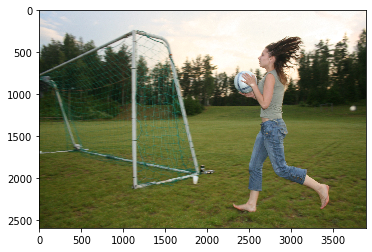

In [7]:
%cd /home/heka/code/image-segmentation/

from main import get_segmented_image, generate_image_old, diff, threshold, cosine_dist
from graph import build_graph_old, segment_graph_old

n = 17

image_url = image_urls[n]
img = image_from_url(image_url)
plt.imshow(img)

img_aug = augs(img)
out = model(img_aug[None].cuda())
if isinstance(out, tuple):
    out = out[1]
out = out[0].permute(1, 2, 0).detach().cpu().numpy()  # [H_out, W_out, 2048]

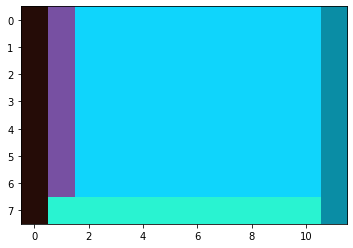

In [8]:
from main import get_segmented_image, generate_image_old, diff, threshold, cosine_dist
from graph import build_graph_old, segment_graph_old

# Params
sigma = 1.
neighbor = 4  # 8 is maybe a bit better, so maybe implement
k = 0.01  # k ~ 10 for euclidean dist, k ~ 0.01 for cosine dist
min_comp_size = 6
dist_fn = cosine_dist
#dist_fn = diff

height, width = out.shape[:2]
graph_edges_old = build_graph_old(out, height, width, dist_fn, neighbor == 4)
forest_old = segment_graph_old(graph_edges_old, height * width, k, min_comp_size, threshold)
segmentation_old = generate_image_old(forest_old, height, width)

plt.imshow(segmentation_old)
plt.show()

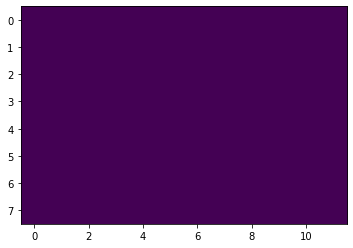

In [9]:
# argmax:
out_classes = np.argmax(out, axis=2).astype(float)
out_classes /= out_classes.max()

plt.imshow(out_classes)
plt.show()


## Patch-wise unsupervised segmentation:

In [3]:
def split_infer_parse_batch(x, patch_size=32):
    # TODO: note reshapes back probably NOT correct!!
    B, C, H, W = x.shape
    out_width = H // 32
    x_patches = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x_patches = x_patches.permute(0, 1, 2, 4, 3, 5).reshape(-1, C, patch_size, patch_size)  # [num_patches * B, 3, patch_size, patch_size]
    y_patches = model(x_patches)  # [num_patches * B, 1000]
    y = y_patches.reshape(B, out_width, out_width, -1)

    return y

# these are also in retrieval_app.core.augs
def patch_cut(x, patch_size):
    """Splits an image to patches of size `patch_size`.
    :param x: shape [B, C, H, W]
    :return x_patches: shape [patch_size ** 2 * B, 3, patch_size, patch_size]

    Args:
        x (torch.tensor): shape [B, C, H, W]
        patch_size (int): square patch width and height

    Returns:
        torch.tensor: shape [patch_size ** 2 * B, 3, patch_size, patch_size]
    """
    # TODO: enforce divisible by `patch_size`
    B, C, H, W = x.shape
    x_patches = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x_patches = x_patches.permute(0, 1, 2, 4, 3, 5)  # [B, C, H // patch_size, W // patch_size, patch_size, patch_size]
    x_patches = x_patches.reshape(-1, C, patch_size, patch_size)

    return x_patches


def patch_parse(img_patches, height, width):
    """Parses image patches created by `patch_cut` back to an image/ feature map.

    Args:
        img_patches (torch.tensor): shape [H // patch_size * W // patch_size * B, 3, patch_size, patch_size]
        height (int): H_image // patch_size; needed for reconstruction
        width (int): W_image // patch_size; needed for reconstruction

    Returns:
        torch.tensor: reconstructed image tensor of shape [B, C, H, W]
    """
    # TODO: doesn't enforce shapes
    batch_times_patches, C, patch_size = img_patches.shape[:3]
    batch_size = batch_times_patches // (height * width)
    img_recon = img_patches.reshape(batch_size, C, height, width, patch_size, patch_size)
    img_recon = img_recon.permute(0, 1, 2, 4, 3, 5)  # [B, C, H/p, p, W/p, p]
    img_recon = img_recon.reshape(batch_size, C, height * patch_size, width * patch_size)

    return img_recon

In [7]:
imgs = list()
image_url = image_urls[17]
img = image_from_url(image_url)
img_aug = augs(img)
print(img_aug.shape)
imgs.append(img_aug)
image_url = image_urls[18]
img = image_from_url(image_url)
img_aug = augs(img)
print(img_aug.shape)
imgs.append(img_aug)

imgs = torch.stack(imgs, dim=0)
imgs.shape

torch.Size([3, 256, 384])
torch.Size([3, 256, 384])


torch.Size([2, 3, 256, 384])

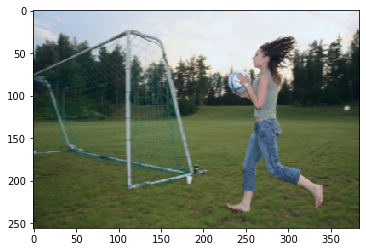

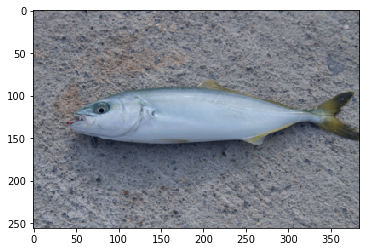

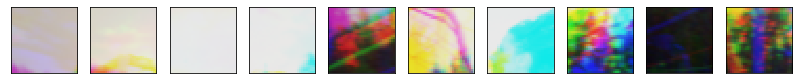

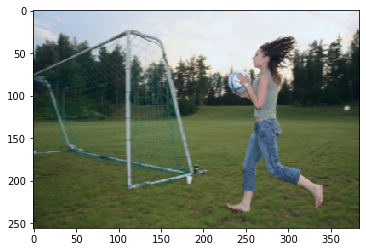

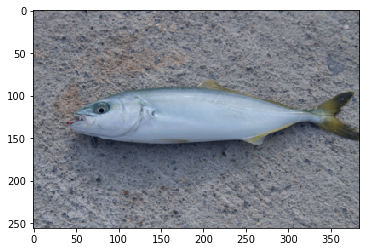

RuntimeError: shape '[0, 3, 256, 384, 32, 32]' is invalid for input of size 589824

In [19]:
img_ = (imgs - imgs.min()) / (imgs.max() - imgs.min())

plt.imshow(img_[0].permute(1, 2, 0))
plt.show()

plt.imshow(img_[1].permute(1, 2, 0))
plt.show()

img_patches = patch_cut(img_, 32)  # [32 ** 2 * B, 3, 32, 32]

num_patch_plots = 10
fig, ax = plt.subplots(1, num_patch_plots, figsize=(14, 6))
# note: cmap below is somehow screwed but should be right
for n in range(num_patch_plots):
    ax[n].imshow(img_patches[n].permute(1, 2, 0).numpy()[:, :, ::-1], vmin=0, vmax=1)
    ax[n].set_xticks([])
    ax[n].set_yticks([])
plt.show()

B = 2
C = 3
H, W = img_.shape[2:]
patch_size = 32
#img_recon = img_pathces.permute(0)
img_recon = img_patches.reshape(B, C, H // patch_size, W // patch_size, patch_size, patch_size)
img_recon = img_recon.permute(0, 1, 2, 4, 3, 5)  # [B, C, H/p, p, W/p, p]
img_recon = img_recon.reshape(B, C, H, W)

plt.imshow(img_recon[0].permute(1, 2, 0))
plt.show()
plt.imshow(img_recon[1].permute(1, 2, 0))
plt.show()

img_recon = patch_parse(img_patches, H, W)
plt.imshow(img_recon[0].permute(1, 2, 0))
plt.show()
plt.imshow(img_recon[1].permute(1, 2, 0))
plt.show()

In [20]:
img_patches = patch_cut(imgs, 32)

out_patches = model(img_patches.cuda())
if isinstance(out_patches, tuple):
    out_patches = out_patches[1]
#out = out[0].permute(1, 2, 0).detach().cpu().numpy()  # [H_out, W_out, 2048]
H, W = imgs.shape[2:]
out_parsed = patch_parse(out_patches, H // 32, W // 32)

In [26]:
out_patches.shape

torch.Size([192, 2048, 1, 1])

/home/heka/code/image-segmentation


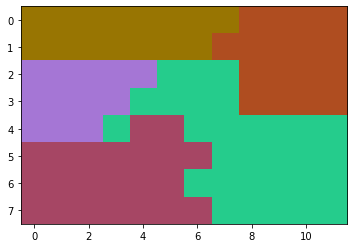

In [25]:
%cd /home/heka/code/image-segmentation/

from main import get_segmented_image, generate_image_old, diff, threshold, cosine_dist
from graph import build_graph_old, segment_graph_old

# Params
sigma = 1.
neighbor = 4  # 8 is maybe a bit better, so maybe implement
k = 0.01  # k ~ 10 for euclidean dist, k ~ 0.01 for cosine dist
min_comp_size = 6
dist_fn = cosine_dist
#dist_fn = diff

b = 1
out = out_parsed[b].permute(1, 2, 0).detach().cpu().numpy()

height, width = out.shape[:2]
graph_edges_old = build_graph_old(out, height, width, dist_fn, neighbor == 4)
forest_old = segment_graph_old(graph_edges_old, height * width, k, min_comp_size, threshold)
segmentation_old = generate_image_old(forest_old, height, width)

plt.imshow(segmentation_old)
plt.show()

## Test graph cut:

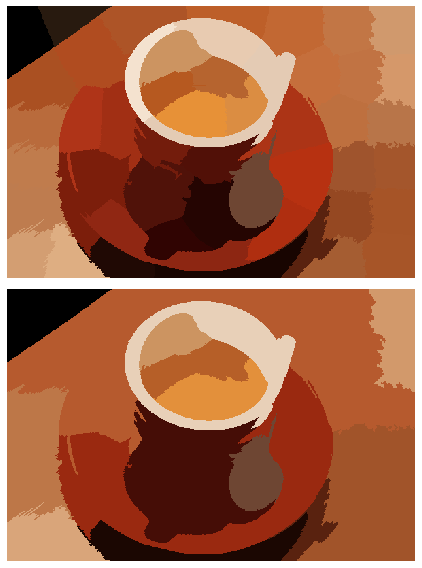

In [178]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = data.coffee()

labels1 = segmentation.slic(img, compactness=30, n_segments=50)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g, num_cuts=4)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

In [179]:
img.shape

(400, 600, 3)

In [165]:
labels1

array([[  0,   0,   0, ...,  24,  24,  24],
       [  0,   0,   0, ...,  24,  24,  24],
       [  0,   0,   0, ...,  24,  24,  24],
       ...,
       [401, 401, 401, ..., 396, 396, 396],
       [401, 401, 401, ..., 396, 396, 396],
       [401, 401, 401, ..., 396, 396, 396]])